**Changelog**
- 2019-02-22: stand alone the sample selection
- 2019-03-01: add link for the plot

In [1]:
%matplotlib inline

# imports and plot settings
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import datetime
from astropy.table import Table
from astropy.io import fits

# autoload the package, for debuge purpose
%load_ext autoreload
%autoreload 2

# set the display properties
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.style.use('default')

# customize the warning message
import warnings
warnings.filterwarnings("default") # default or ignore

today = datetime.date.today().isoformat()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# AGN Selection

## Methods: 
1. 'BPT AGN' + 'EW(Ha)>3 Angstrom' (reduce DIG contribution)
2. 2/3 spaxels classified as AGN through the BPT diagnosis (resolved by MaNGA)

In [ ]:
# Purpose: select AGN by it's central 3'' region with persentage greater than 60%
# History:
#   - 2018-04-13: first added
#   - 2018-04-15: add the bptx, bpty and EW(Ha) to help plot the BPT diagram
#   - 2018-04-26: add the is_low_limit valuse for those unresolved ENLR, and is_binary from data/binary.txt
#   - 2018-05-04: add the edge_on likelihood from data/edge_on.txt
#   - 2018-06-01: update pair galaxy by include some pair galaxy, if it's OIII not effect our results
#                 change is_low_limit to is_limit, by default low_limit=1
#   - 2018-06-27: change the handling of exception
#   - 2018-09-03: using the median value of BPT-x, BPT-y and EW(Ha) of AGN region instead of mean
#   - 2018-11-04: clean up the code and modify the output
#   - 2018-12-24: update for MPL-7(DR15)

import mangatools as mangatools_package
from mangatools.manga import MaNGA, DAP
from mangatools.maps import Maps
from mangatools import utils

dap = DAP
use_AGN = True
use_composite = False
use_HaEW = True
is_debug = False
data_string = "{} {} {} {} {} {} {} {} {} \n" 
data_items = ["plateifu", "ra", "dec", "mangaid","BPT_x","BPT_y", "EW_Ha", "is_limit", "edge_on"]

# select all the MPL7 galaxies
dap_mpl7 = dap[dap['DAPTYPE'] == 'HYB10-GAU-MILESHC']

# read galaxy pairs and edge-on galaxies from visual classification
binaries = Table.read('data/binary.txt', format='ascii')
# exclude the binaries that their ENLR were overlapped with each other 
binaries_exclude = binaries[binaries['exclude'] == 1] 
edge_ons = Table.read('data/edge_on.txt', format='ascii')

mangaid_list = []
error_list = []
abandon_list = []
nodata_list = []
# if has the AGN regions
if use_AGN:
    agn_list = []
    agn_binaries = []
    f_agn = open('data/AGNs-'+today+'.dat', 'w')
    f_agn.write("# the selected AGNs\n")
    f_agn.write(data_string.format(*data_items))

abandon_list = []
# exclude galaxies, either not AGN or not (AGN + composite)
f_exclude = open('data/AGNs-exclude-'+today+'.dat', 'w')
f_exclude.write("# the excluded, use_AGN is {}, use_composite is {}\n".format(use_AGN, use_composite))
f_exclude.write(data_string.format(*data_items))

# used for counting
ct = 1
total = len(dap_mpl7[:])

# loop through all the MPL6
for glx in range(total):
    plateifu = dap_mpl7['PLATEIFU'][glx]
    if is_debug:
        print('plateifu: {}'.format(plateifu))
    try:
        g = Maps(plateifu)
    except Exception as ex:
        if is_debug:
            print("{}: {}".format(plateifu, ex))
        error_list.append(plateifu)
        ct += 1
        continue
    mangaid = g.mangaid
    # deal with repeated observation
    if mangaid in mangaid_list:
        abandon_list.append(plateifu)
        ct += 1
        if is_debug:
            print(plateifu, 'is repeatedly oberserved')
        continue
    if plateifu in binaries_exclude['plateifu']:
        agn_binaries.append(plateifu)
        ct += 1
        continue
    if len(g.repeat) > 0:
        plateifu = g.alter
        mangaid_list.append(mangaid)
        g = Maps(plateifu)
    
    agn, cp, sf, *other = g.bptregion()
    r, rr, phi = g.maps['SPX_ELLCOO'].data
    inner3deg = utils.sector_binning(r, phi, r_max=3.0)
    innerpsf = utils.sector_binning(r, phi, r_max=g.psf/2)
    ewHa_region = g.line_ew('Ha-6564') > 3
    if use_composite:
        agn = agn | cp
    if use_HaEW:
        select_region = agn & inner3deg & ewHa_region
    else:
        select_region = agn & inner3deg

    agn_frac = np.sum(select_region)/np.sum(inner3deg)
    if agn_frac > 0.66:
        agn_list.append(plateifu)
        rmax = np.max(r[select_region])
        if rmax > g.psf/2: 
            is_limit = 0
        else:
            is_limit = 1 #upper limit, unresolved
        if plateifu in edge_ons['plateifu']:
            edge_on_likelihood = edge_ons['likelihood'][edge_ons['plateifu']==plateifu][0]
        else:
            edge_on_likelihood = 0
        f_agn.write(data_string.format(
                plateifu, g.ra, g.dec, mangaid, np.ma.median(g.bptx[select_region]), 
                np.ma.median(g.bpty[select_region]), 
                np.ma.median(g.line_ew('Ha-6564')[select_region]),
                is_limit, edge_on_likelihood))
    else:
        bptx = np.ma.median(g.bptx[inner3deg])
        bpty = np.ma.median(g.bpty[inner3deg])
        if np.ma.is_masked(bptx) or np.ma.is_masked(bpty):
            nodata_list.append(plateifu)
            if is_debug:
                print(plateifu, 'have no data in BPT diagram')
            ct += 1
            continue
        f_exclude.write(data_string.format(
                plateifu, g.ra, g.dec, mangaid, bptx, bpty, 
                np.ma.median(g.line_ew('Ha-6564')[inner3deg]),
                0, 0))
    if not is_debug:
        utils.processBar(total, ct)
        ct += 1

print("\n{} agns have found. Besides, {} in binaries, but {} errors, {} have no BPT data".format(
      len(agn_list), len(agn_binaries), len(error_list), len(nodata_list)))
print("AGNs Write into {}".format(f_agn.name))
print("Others exclude AGNs Write into {}".format(f_exclude.name))
f_agn.close()
f_exclude.close()

## Visualization

### All the sample in BPT diagram

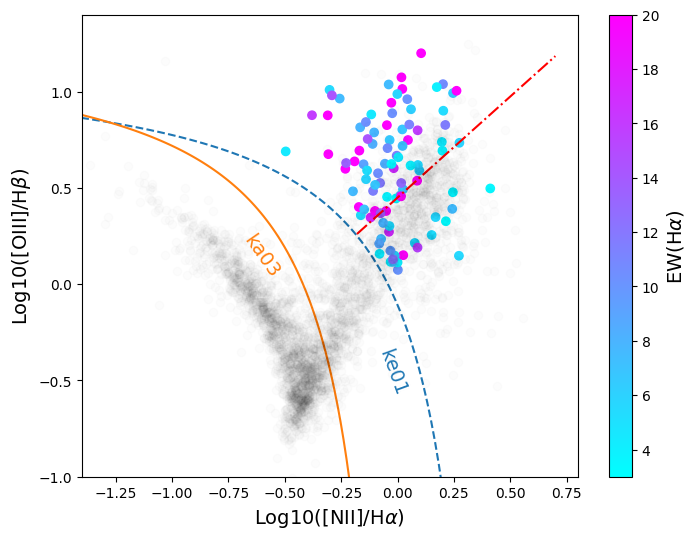

In [2]:
# Plot all the sample in the BPT diagram
# History:
#   2018-10-04: add the history

# set for background PPT
plt.style.use('default')

f_agn = Table.read('./data/AGNs-2019-03-20.dat', format='ascii')
f_exclude = Table.read('./data/AGNs-exclude-2019-03-20.dat', format='ascii')
#exclude_binary = (f_agn['is_binary'] == '0')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# plot the line
x1 = np.linspace(-1.5, 0.2, 100)
ke01 = 0.61/(x1-0.47)+1.19
x2 = np.linspace(-1.5, -.2, 100)
ka03 = 0.61/(x2-0.05)+1.3
x3 = np.linspace(-0.18, 0.7, 100)
schawinski_line = 1.05*x3+0.45
ax.plot(x1, ke01, '--', color='C0') 
ax.text(-0.7, 0.2, 'ka03', rotation=-55, fontsize=14, color='C1')
ax.plot(x2, ka03, 'C1') 
ax.text(-0.1, -0.4, 'ke01', rotation=-70, fontsize=14, color='C0')
ax.plot(x3, schawinski_line, 'r-.')

# first plot all the non-AGN galaxies as background
subfig1 = ax.plot(f_exclude['BPT_x'], f_exclude['BPT_y'], 'ko',label='DR15', alpha=0.01)

# plot all the AGNs with colorbar show it's EW(Ha)
subfig2 = ax.scatter(f_agn['BPT_x'], f_agn['BPT_y'], c=f_agn['EW_Ha'], label="AGN",
                     cmap='cool', vmin=3, vmax=20)

cbar = fig.colorbar(subfig2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(r'EW(H$\alpha$)', fontsize=14)

ax.set_xlim((-1.4, 0.8))
ax.set_ylim((-1., 1.4))
ax.set_xlabel(r'Log10([NII]/H$\alpha)$', fontsize=14)
ax.set_ylabel(r'Log10([OIII]/H$\beta)$', fontsize=14)

#ax.legend(fontsize=14)

# save figure to file
fig.savefig("./results/all_sample.pdf", bbox_inches='tight')